In [1]:
import argparse
import scipy.io as scio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import random
from utils import weights_init, compute_acc
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt


 # 输入参数

In [343]:
parser = argparse.ArgumentParser()
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=1, help='input batch size')
parser.add_argument('--signalFeatures', type=int, default=6, help='the features of signal')
parser.add_argument('--signalPoints', type=int, default=6, help='the points of signal')
parser.add_argument('--nz', type=int, default=110, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--num_classes', type=int, default=10, help='Number of classes for AC-GAN')
parser.add_argument('--gpu_id', type=int, default=0, help='The ID of the specified GPU')
parser.add_argument('--window', type=int, default=4, help='The size of slide window')
parser.add_argument('--slide_stride', type=int, default=1, help='The stride of slide window')

opt = parser.parse_args(['--cuda',
                         '--batchSize','500',
                         '--niter','500',
                         '--workers','0',
                         '--gpu_id','0',
                         '--nz','100',
                         '--num_classes','6',
                         '--signalFeatures','1',
                         '--signalPoints','4',
                         '--window','4',
                         '--slide_stride','1',
                         '--lr','0.0001'])
print(opt)

# specify the gpu id if using only 1 gpu
if opt.ngpu == 1:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(opt.gpu_id)

device = torch.device("cuda:"+str(opt.gpu_id) if torch.cuda.is_available() else "cpu")


try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.cuda:
    torch.cuda.manual_seed_all(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")


# some hyper parameters
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
num_classes = int(opt.num_classes)
nc = 3



Namespace(batchSize=500, beta1=0.5, cuda=True, gpu_id=0, lr=0.0001, manualSeed=None, ndf=64, netD='', netG='', ngf=64, ngpu=1, niter=500, num_classes=6, nz=100, outf='.', signalFeatures=1, signalPoints=4, slide_stride=1, window=4, workers=0)
Random Seed:  892


In [344]:
# 导入数据
data_1 = torch.from_numpy(scio.loadmat("mode_1_data.mat")['X_train']).type(torch.float32).unsqueeze(2).to(device)
data_2 = torch.from_numpy(scio.loadmat("mode_2_data.mat")['X_train']).type(torch.float32).unsqueeze(2).to(device)
data_3 = torch.from_numpy(scio.loadmat("mode_3_data.mat")['X_train']).type(torch.float32).unsqueeze(2).to(device)
data_4 = torch.from_numpy(scio.loadmat("mode_4_data.mat")['X_train']).type(torch.float32).unsqueeze(2).to(device)
data_5 = torch.from_numpy(scio.loadmat("mode_5_data.mat")['X_train']).type(torch.float32).unsqueeze(2).to(device)
data_6 = torch.from_numpy(scio.loadmat("mode_6_data.mat")['X_train']).type(torch.float32).unsqueeze(2).to(device)


In [345]:
# 滑窗

def slide_window_data(data, window, stride):
    # data: torch.ndarray samples*features*1
    new_data = data[:-window,:,:]
    for i in range(1,window):
        new_data = torch.cat((new_data,data[i:-window+i,:,:]),2)
    

    output = new_data[[x*stride for x in range((new_data.shape[0]-1)//stride+1)], :, :]

    return output



In [346]:
real_data_1 = slide_window_data(data_1, opt.window, opt.slide_stride)
real_data_2 = slide_window_data(data_2, opt.window, opt.slide_stride)
real_data_3 = slide_window_data(data_3, opt.window, opt.slide_stride)
real_data_4 = slide_window_data(data_4, opt.window, opt.slide_stride)
real_data_5 = slide_window_data(data_5, opt.window, opt.slide_stride)
real_data_6 = slide_window_data(data_6, opt.window, opt.slide_stride)



In [347]:
# 数据加载DataLoader
x_data = torch.cat((real_data_1,real_data_2,real_data_3,real_data_4,real_data_5,real_data_6),0)
label_1 = torch.zeros(real_data_1.shape[0])
label_2 = torch.ones(real_data_2.shape[0])
label_3 = torch.ones(real_data_3.shape[0])*2
label_4 = torch.ones(real_data_4.shape[0])*3
label_5 = torch.ones(real_data_5.shape[0])*4
label_6 = torch.ones(real_data_6.shape[0])*5
y_data = torch.cat((label_1,label_2,label_3,label_4,label_5,label_6))

In [348]:
# 临时 去除正常数据
# x_data = torch.cat((real_data_2,real_data_3,real_data_4,real_data_5,real_data_6),0)
# # label_1 = torch.zeros(real_data_1.shape[0])
# label_2 = torch.zeros(real_data_2.shape[0])
# label_3 = torch.ones(real_data_3.shape[0])*1
# label_4 = torch.ones(real_data_4.shape[0])*2
# label_5 = torch.ones(real_data_5.shape[0])*3
# label_6 = torch.ones(real_data_6.shape[0])*4
# y_data = torch.cat((label_2,label_3,label_4,label_5,label_6))

In [349]:
x_data = x_data[:,0:opt.signalFeatures,:]

In [350]:
deal_dataset = TensorDataset(x_data, y_data)
dataloader = DataLoader(dataset=deal_dataset,
                        batch_size=opt.batchSize,
                        shuffle=True,
                        num_workers=opt.workers)

In [351]:
# 定义生成器
class _netG(nn.Module):
    def __init__(self, opt):
        super().__init__()
        self.ngpu = int(opt.ngpu)
        self.nz = int(opt.nz)
        self.points = int(opt.signalPoints)
        self.batch_size = int(opt.batchSize)
        self.features = int(opt.signalFeatures)

        self.fc1 = nn.Linear(100,36)
        # output batchsize*36*1

        self.tconv2 = nn.Sequential(
            nn.ConvTranspose1d(36,18,2,1,0, bias=False),
            nn.BatchNorm1d(18),
            nn.ReLU(True)
        )# output batchsize*channel(dim)*points batchsize*18*2

        self.tconv3 = nn.Sequential(
            nn.ConvTranspose1d(18,9,2,1,0, bias=False),
            nn.BatchNorm1d(9),
            nn.ReLU(True)
        )# output batchsize*channel(dim)*points batchsize*6*4

        self.tconv4 = nn.Sequential(
            nn.ConvTranspose1d(9,opt.signalFeatures,self.points-2,1,0, bias=False),
            nn.BatchNorm1d(opt.signalFeatures),
            nn.ReLU(True)
        )# output batchsize*channel(dim)*points batchsize*9*3

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            input = input.view(-1, self.nz)
            fc1 = nn.parallel.data_parallel(self.fc1, input, range(self.ngpu))
            fc1 = fc1.view(-1, 36, 1)
            tconv2 = nn.parallel.data_parallel(self.tconv2, fc1, range(self.ngpu))
            tconv3 = nn.parallel.data_parallel(self.tconv3, tconv2, range(self.ngpu))
            tconv4 = nn.parallel.data_parallel(self.tconv4, tconv3, range(self.ngpu))
            output = tconv4
        else:
            input = input.view(-1, self.nz)
            fc1 = self.fc1(input)
            fc1 = fc1.view(-1, 36, 1)
            tconv2 = self.tconv2(fc1)
            tconv3 = self.tconv3(tconv2)
            tconv4 = self.tconv4(tconv3)
            output = tconv4
        return output



In [352]:
# 定义鉴别器
class _netD(nn.Module):
    def __init__(self, opt):
        super().__init__()
        self.ngpu = int(opt.ngpu)
        self.num_classes = opt.num_classes
        self.points = int(opt.signalPoints)
        self.features = int(opt.signalFeatures)

        self.conv1 = nn.Sequential(
            nn.Conv1d(opt.signalFeatures,12,2,1,0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False)
        )# output [1, 12, 3]
        self.conv2 = nn.Sequential(
            nn.Conv1d(12,24,2,1,0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False)
        )# output [1, 24, 1]
        self.conv3 = nn.Sequential(
            nn.Conv1d(24,48,2,1,0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False)
        )# output [1, 48, 1]

        self.fc_dis = nn.Linear(48*(self.points-3), 1)
        self.fc_aux = nn.Linear(48*(self.points-3), self.num_classes)
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        batchsize = input.shape[0]
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            conv1 = nn.parallel.data_parallel(self.conv1, input, range(self.ngpu))
            conv2 = nn.parallel.data_parallel(self.conv2, conv1, range(self.ngpu))
            conv3 = nn.parallel.data_parallel(self.conv3, conv2, range(self.ngpu))
            flat3 = conv3.view(-1, 48*1)
            fc_dis = nn.parallel.data_parallel(self.fc_dis, flat3, range(self.ngpu))
            fc_aux = nn.parallel.data_parallel(self.fc_aux, flat3, range(self.ngpu))
        else:
            conv1 = self.conv1(input)
            conv2 = self.conv2(conv1)
            conv3 = self.conv3(conv2)
            flat3 = conv3.view(batchsize, -1)
            fc_dis = self.fc_dis(flat3)
            fc_aux = self.fc_aux(flat3)
        classes = self.softmax(fc_aux)
        realfake = self.sigmoid(fc_dis).view(-1, 1).squeeze(1)
        return realfake, classes



In [353]:
# 初始化生成器和鉴别器
netG = _netG(opt).to(device)
netG.apply(weights_init)
netD = _netD(opt).to(device)
netD.apply(weights_init)


_netD(
  (conv1): Sequential(
    (0): Conv1d(1, 12, kernel_size=(2,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(12, 24, kernel_size=(2,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(24, 48, kernel_size=(2,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc_dis): Linear(in_features=48, out_features=1, bias=True)
  (fc_aux): Linear(in_features=48, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
)

In [354]:
# 定义鉴别和辅助分类损失函数
dis_criterion = nn.BCELoss().to(device)
aux_criterion = nn.NLLLoss().to(device)


 # 定义优化器

In [355]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))


 # 训练

 # 初始化变量

In [356]:
# tensor placeholders
noise = torch.FloatTensor(opt.batchSize, nz, 1).to(device)
dis_label = torch.FloatTensor(opt.batchSize).to(device)
aux_label = torch.LongTensor(opt.batchSize).to(device)
real_label = 1
fake_label = 0

In [357]:
avg_loss_D = 0.0
avg_loss_G = 0.0
avg_loss_A = 0.0

In [365]:
for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        if epoch==400:
            pass

        #############################
        ## (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        #############################
        # train with real
        netD.zero_grad()
        real_cpu, label = data
        input_samples = real_cpu
        batch_size = real_cpu.shape[0]
        dis_label.resize_(batch_size).fill_(real_label)
        aux_label.resize_(batch_size).copy_(label)
        dis_output, aux_output = netD(input_samples)

        dis_errD_real = dis_criterion(dis_output, dis_label)
        aux_errD_real = aux_criterion(aux_output, aux_label)
        errD_real = dis_errD_real + aux_errD_real
        errD_real.backward()
        D_x = dis_output.mean()

        # compute the current classification accuracy
        accuracy = compute_acc(aux_output, aux_label)

        # train with fake
        label = torch.randint_like(aux_label, 0, num_classes)
        noise = torch.randn(batch_size, nz,1,1).to(device)
        class_onehot = torch.zeros((batch_size, num_classes)).to(device)
        class_onehot[np.arange(batch_size), label] = 1
        noise[np.arange(batch_size), :num_classes, 0, 0] = class_onehot[np.arange(batch_size)]
        aux_label.copy_(label)

        fake = netG(noise)
        dis_label.fill_(fake_label)
        dis_output, aux_output = netD(fake.detach())
        dis_errD_fake = dis_criterion(dis_output, dis_label)
        aux_errD_fake = aux_criterion(aux_output, aux_label)
        errD_fake = dis_errD_fake + aux_errD_fake
        errD_fake.backward()
        D_G_z1 = dis_output.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        #############################
        ## (2) Update G network: maximize log(D(G(z)))
        #############################
        netG.zero_grad()
        dis_label.fill_(real_label)
        dis_output, aux_output = netD(fake)
        dis_errG = dis_criterion(dis_output, dis_label)
        aux_errG = aux_criterion(aux_output, aux_label)
        errG = dis_errG + aux_errG
        errG.backward()
        D_G_z2 = dis_output.mean()
        optimizerG.step()

        # compute the average loss
        curr_iter = 1
        all_loss_G = avg_loss_G * curr_iter
        all_loss_D = avg_loss_D * curr_iter
        all_loss_A = avg_loss_A * curr_iter
        all_loss_G += errG.item()
        all_loss_D += errD.item()
        all_loss_A += accuracy
        avg_loss_G = all_loss_G / (curr_iter + 1)
        avg_loss_D = all_loss_D / (curr_iter + 1)
        avg_loss_A = all_loss_A / (curr_iter + 1)
        print('[%d/%d][%d/%d] Loss_D: %.4f (%.4f) Loss_G: %.4f (%.4f) D(x): %.4f D(G(z)): %.4f / %.4f Acc: %.4f (%.4f)'
                % (epoch, opt.niter, i, len(dataloader),
                errD.item(), avg_loss_D, errG.item(), avg_loss_G, D_x, D_G_z1, D_G_z2, accuracy, avg_loss_A))



.5029) Loss_G: 0.5982 (0.5919) D(x): 0.9194 D(G(z)): 0.3815 / 0.3842 Acc: 67.6000 (66.9242)
[473/500][4/6] Loss_D: -0.4893 (-0.4961) Loss_G: 0.5776 (0.5847) D(x): 0.9153 D(G(z)): 0.3881 / 0.3881 Acc: 69.0000 (67.9621)
[473/500][5/6] Loss_D: -0.4794 (-0.4877) Loss_G: 0.6031 (0.5939) D(x): 0.9203 D(G(z)): 0.3866 / 0.3861 Acc: 68.0672 (68.0147)
[474/500][0/6] Loss_D: -0.4992 (-0.4935) Loss_G: 0.5916 (0.5927) D(x): 0.9139 D(G(z)): 0.3788 / 0.3777 Acc: 66.6000 (67.3073)
[474/500][1/6] Loss_D: -0.5123 (-0.5029) Loss_G: 0.5704 (0.5816) D(x): 0.9141 D(G(z)): 0.3819 / 0.3847 Acc: 68.4000 (67.8537)
[474/500][2/6] Loss_D: -0.4607 (-0.4818) Loss_G: 0.5830 (0.5823) D(x): 0.9121 D(G(z)): 0.3841 / 0.3838 Acc: 64.2000 (66.0268)
[474/500][3/6] Loss_D: -0.4878 (-0.4848) Loss_G: 0.5749 (0.5786) D(x): 0.9105 D(G(z)): 0.3834 / 0.3833 Acc: 67.2000 (66.6134)
[474/500][4/6] Loss_D: -0.5050 (-0.4949) Loss_G: 0.6009 (0.5897) D(x): 0.9130 D(G(z)): 0.3810 / 0.3813 Acc: 68.8000 (67.7067)
[474/500][5/6] Loss_D: -0.

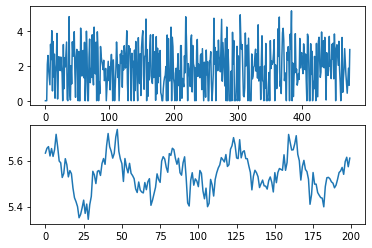

In [366]:
label = torch.randint_like(aux_label, 0, num_classes)
label[:] = 1-1
noise = torch.randn(batch_size, nz,1,1).to(device)
class_onehot = torch.zeros((batch_size, num_classes)).to(device)
class_onehot[np.arange(batch_size), label] = 1
noise[np.arange(batch_size), :num_classes, 0, 0] = class_onehot[np.arange(batch_size)]
aux_label.copy_(label)

fake = netG(noise)
plot_fake_sample = fake.detach().cpu()
plt.figure()
plt.subplot(2,1,1)
plt.plot(plot_fake_sample[:,:,0])
plt.subplot(2,1,2)
plt.plot(data_5[:,:opt.signalFeatures,0].detach().cpu())
plt.savefig('fig1.png')

In [360]:
torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))